In [12]:
%load_ext autoreload
%autoreload 2
    
from bosonicplus.base import State as olga_state
from bosonicplus.plotting import plot_wigner_marginals
from bosonicplus.states.from_sf import prepare_gkp_bosonic
from bosonicplus.fidelity import fidelity_bosonic_new
from thewalrus.symplectic import beam_splitter, squeezing, xxpp_to_xpxp, expand
from matplotlib import pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
from mrmustard.lab_dev import Sauron
from mrmustard.lab import *
import numpy as np
from time import time

In [14]:
#Uh oh, mrmustard also seems to have implemented the fock as coherent state superpos

def mrmustard_circuit_sauron(nmodes, r, eta, n):
    
    state = Vacuum(nmodes)
    for i in range(nmodes):
        state = state >> Sgate(r, i%2*np.pi)[i]
        
    for i in range(nmodes):
        if i < nmodes -1:
            BS = BSgate(modes = [i,i+1],theta = np.pi/4)
            state = state >> BS
    if eta != 1:
        state = state >> Attenuator(eta, modes = range(nmodes))
    for i in range(nmodes-1):
        state_post = state << Sauron([i], n)

    return state_post

In [15]:
#Lucky for me, this doesn't seem to work yet. 
state = mrmustard_circuit_sauron(3, 1.5, 1, 10)

AttributeError: 'Sauron' object has no attribute 'primal'

## Comparing performance of a fixed circuit between mr mustard and bosonicplus

In [5]:
def mrmustard_circuit(nmodes, r, eta, n):

    state = Vacuum(nmodes)
    for i in range(nmodes):
        state = state >> Sgate(r, i%2*np.pi)[i]
        
    for i in range(nmodes):
        if i < nmodes -1:
            BS = BSgate(modes=[i,i+1],theta = np.pi/4)
            state = state >> BS
    if eta != 1:
        
        state = state >> Attenuator(eta, modes = range(nmodes))
        
    
    state_post = state << Fock([n]*(nmodes-1), range(nmodes-1))

    return state_post
           

In [6]:
def bosonicplus_circuit(nmodes, r, eta, n):
    state = olga_state(nmodes)
    bs = xxpp_to_xpxp(beam_splitter(np.pi/4,0))

    for i in range(nmodes):
        
        state.apply_symplectic_fast(xxpp_to_xpxp(squeezing(r, i%2*np.pi)),[i])
    for i in range(nmodes):
        if i < nmodes-1:
            state.apply_symplectic_fast(bs, [i,i+1])
    if eta != 1:
        state.apply_loss(np.repeat(eta,nmodes),np.zeros(nmodes))
    
    
    for i in range(nmodes-1):
        state.post_select_fock_coherent(0,n,red_gauss =True)
    return state
    


def bosonicplus_wigner(state):
    xvec = np.linspace(-8,8,200)
    W = state.get_wigner_bosonic(xvec,xvec)
    return W
    

#### State

| Purity | Probability | Num modes | Bosonic size | Gaussian | Fock |
| :----: | :----: | :----: | :----: | :----: | :----: |
| 2.02e-01 | 3.231e-04 % | 1 | N/A | ❌ | ✅ |

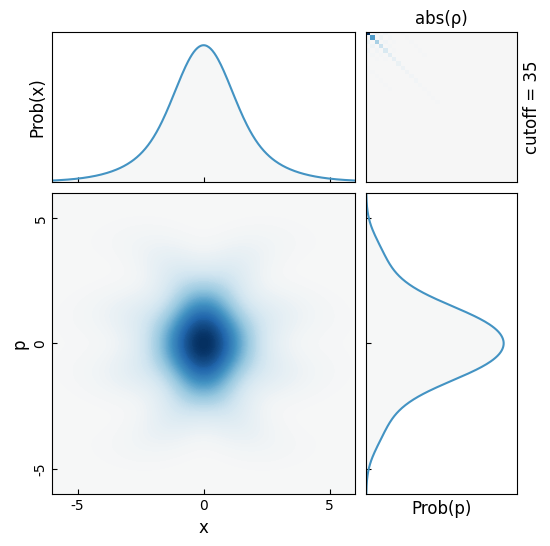

In [11]:
state = mrmustard_circuit(4,1.5,0.5,10)
print(state.probability)
state

/Users/s163967/venv/mrmustard_test/lib/python3.12/site-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/s163967/venv/mrmustard_test/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/s163967/Library/CloudStorage/OneDrive-DanmarksTekniskeUniversitet/Git_Repos/bosonicplus/src/bosonicplus/plotting.py:174: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


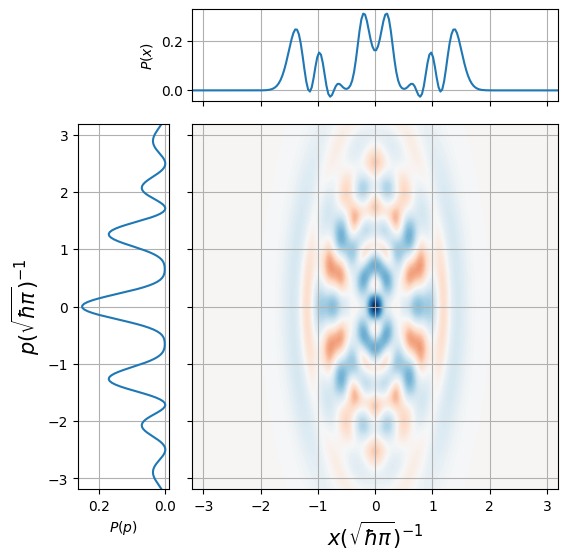

In [9]:
state = bosonicplus_circuit(3,1.5,1,5)
xvec = np.linspace(-8,8,200)
W = state.get_wigner_bosonic(xvec,xvec)
plot_wigner_marginals(W,xvec,xvec,'')
plt.show()

## First, do the lossless comparison

In [22]:
modes = np.array([3,4])
photons = np.array([1,5,8])
times_mm = np.zeros((len(modes),len(photons), 2))
times_bp = np.zeros((len(modes),len(photons), 2))
r = 1.5
eta = 1

for i, m in enumerate(modes):
    for j, n in enumerate(photons):
        print(f'modes {m}, detecting {n} photons')
        
        t1 = %timeit -o mrmustard_circuit(m,r,eta,n)
        
        times_mm[i,j,0] = t1.average

        t2 = %timeit -o bosonicplus_circuit(m,r,eta,n)
               
        times_bp[i,j,0] = t2.average
        

modes 3, detecting 1 photons
3.51 ms ± 148 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
499 μs ± 1.05 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
modes 3, detecting 5 photons
3.91 ms ± 285 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
926 μs ± 28.9 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
modes 3, detecting 8 photons
4.34 ms ± 509 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.64 ms ± 121 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
modes 4, detecting 1 photons
6.36 ms ± 815 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
817 μs ± 75.2 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
modes 4, detecting 5 photons
6.46 ms ± 781 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
2.97 ms ± 157 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
modes 4, detecting 8 photons
6.71 ms ± 323 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
21.1 ms ± 1 ms per loop (mean ± std. de

## Now, with loss

In [23]:
eta = 0.8

for i, m in enumerate(modes):
    for j, n in enumerate(photons):
        print(f'modes {m}, detecting {n} photons')
        t1 = %timeit -o mrmustard_circuit(m,r,eta,n)
        
        times_mm[i,j,1] = t1.average

        t2 = %timeit -o bosonicplus_circuit(m,r,eta,n)
               
        times_bp[i,j,1] = t2.average

modes 3, detecting 1 photons
5.36 ms ± 749 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
527 μs ± 20.8 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
modes 3, detecting 5 photons
115 ms ± 11.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
1.08 ms ± 87 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
modes 3, detecting 8 photons
445 ms ± 21.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.65 ms ± 123 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
modes 4, detecting 1 photons
13.3 ms ± 1.43 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
819 μs ± 91.6 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
modes 4, detecting 5 photons
2.84 s ± 76.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.84 ms ± 175 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
modes 4, detecting 8 photons
45.4 s ± 1.66 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
25.3 ms ± 4.48 ms per loop (mean ± std. dev. of 

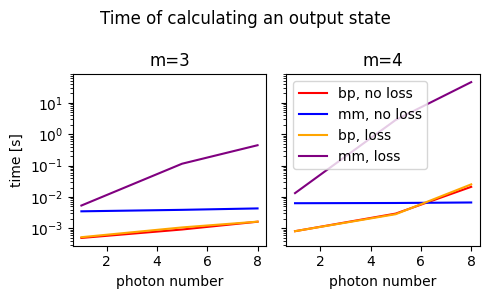

In [44]:
fig, axes = plt.subplots(1,2,figsize =(5,3),sharey=True,sharex=True)


for i, m in enumerate(modes):
    axes[i].plot(photons,times_bp[i,:,0], color = 'red', label = 'bp, no loss')
    axes[i].plot(photons,times_mm[i,:,0], color ='blue', label = 'mm, no loss')
    
    axes[i].plot(photons,times_bp[i,:,1], color = 'orange',label='bp, loss')
    axes[i].plot(photons,times_mm[i,:,1], color ='purple', label = 'mm, loss')
    axes[i].set_yscale('log')

fig.suptitle('Time of calculating an output state')
axes[0].set_title('m=3')
axes[1].set_title('m=4')
axes[0].set_xlabel('photon number')
axes[1].set_xlabel('photon number')
axes[0].set_ylabel('time [s]')
axes[1].legend()
fig.set_tight_layout('tight')
plt.show()

In [47]:
state = mrmustard_circuit(4,1,0.8,4)

In [23]:
modes = np.arange(3,5,2)
photons = np.arange(1,16,5)
times_bosonic = np.zeros((len(modes),len(photons)))
times_wig = np.zeros((len(modes),len(photons)))
r = 1.5
eta = 0.8

for i, m in enumerate(modes):
    for j, n in enumerate(photons):
        print(f'modes {m}, detecting {n} photons')
        timeres = %timeit -o bosonicplus_circuit(m,r,eta,n)
        times[i,j] = timeres.average

        state = bosonicplus_circuit(m,r,eta,n)

        time_wig = %timeit -o bosonicplus_wigner(state)
        times_wig[i,j] = time_wig.average
        
        print('--'*50)

modes 3, detecting 1 photons
515 μs ± 3.37 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
6.15 ms ± 13.7 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
----------------------------------------------------------------------------------------------------
modes 3, detecting 6 photons
1.09 ms ± 10.4 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
891 ms ± 23.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
----------------------------------------------------------------------------------------------------
modes 3, detecting 11 photons
2.69 ms ± 201 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
8.75 s ± 830 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
----------------------------------------------------------------------------------------------------
modes 5, detecting 1 photons
991 μs ± 12.1 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
92.9 ms ± 1.28 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
-----------

KeyboardInterrupt: 

In [33]:
state = bosonicplus_circuit(,1.5,0.8,5)
gkp = prepare_gkp_bosonic([0,0],0.1)

#print(state.num_weights)
#xvec = np.linspace(-10,10,200)
#W= state.get_wigner_bosonic(xvec,xvec)

In [ ]:
fidelity_bosonic_new(state, gkp)

#### State

| Purity | Probability | Num modes | Bosonic size | Gaussian | Fock |
| :----: | :----: | :----: | :----: | :----: | :----: |
| 1.35e-01 | 0.324% | 1 | N/A | ❌ | ✅ |

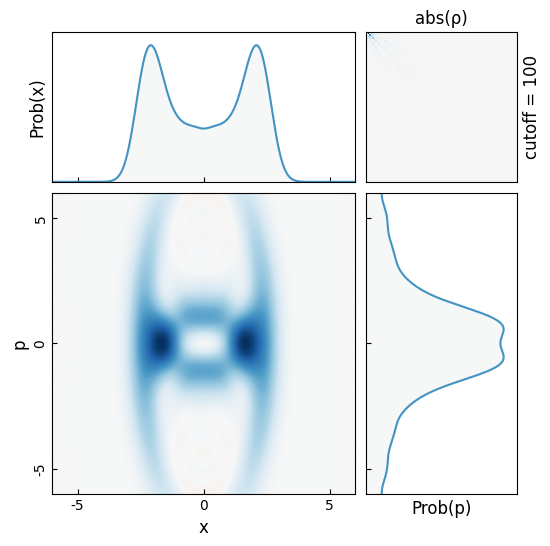

In [29]:
time_mrmustard(3,2,0.8,5)

#### State

| Purity | Probability | Num modes | Bosonic size | Gaussian | Fock |
| :----: | :----: | :----: | :----: | :----: | :----: |
| 1.19e-01 | 1.326e-02 % | 1 | N/A | ❌ | ✅ |

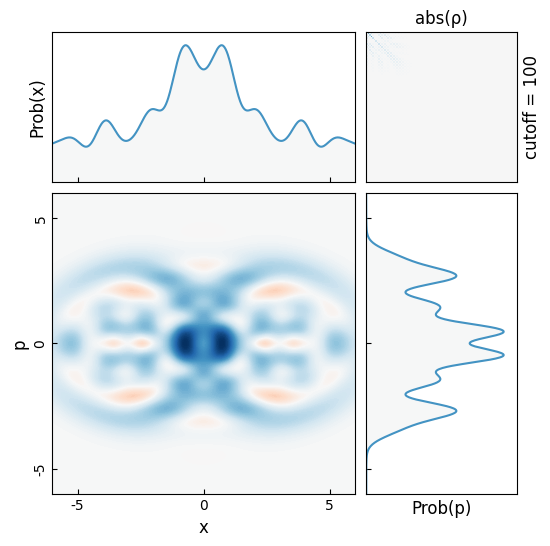

In [137]:
state1

In [139]:
t0 = time()
state = olga_state(4)
S1 = expand(squeezing(2),0,4)
S2 = expand(squeezing(2,np.pi),1,4)
state.apply_symplectic(xxpp_to_xpxp(S1))
state.apply_symplectic(xxpp_to_xpxp(S2))
S1 = expand(squeezing(2),2,4)
S2 = expand(squeezing(2,np.pi),3,4)
state.apply_symplectic(xxpp_to_xpxp(S1))
state.apply_symplectic(xxpp_to_xpxp(S2))

state.apply_loss(np.repeat(0.9,4),np.zeros(4))

BS = expand(beam_splitter(np.pi/4,0),[0,1],4)
state.apply_symplectic(xxpp_to_xpxp(BS))
BS = expand(beam_splitter(np.pi/4,0),[1,2],4)
state.apply_symplectic(xxpp_to_xpxp(BS))
BS = expand(beam_splitter(np.pi/4,0),[2,3],4)
state.apply_symplectic(xxpp_to_xpxp(BS))


ns = np.repeat(5,3)
for i,n in enumerate(ns):
    state.post_select_fock_coherent(0,n,inf=1e-5,red_gauss =True)
t1 = time()

W = state.get_wigner_bosonic(x,x)
t2 = time()
print(state.norm)
print(state.num_weights)
print(f'total time bosonicplus: {t2-t0} s')
print(f'time to caculate output state: {t1-t0} s')
print(f'time to calculate wigner function: {t2-t1} s')

0.00013297188209726585
23436
total time bosonicplus: 4.42716908454895 s
time to caculate output state: 0.011644363403320312 s
time to calculate wigner function: 4.41552472114563 s


(<Figure size 600x600 with 3 Axes>,
 <Axes: xlabel='$x(\\sqrt{\\hbar\\pi})^{-1}$'>,
 <Axes: ylabel='$P(x)$'>,
 <Axes: xlabel='$P(p)$', ylabel='$p(\\sqrt{\\hbar\\pi})^{-1}$'>)

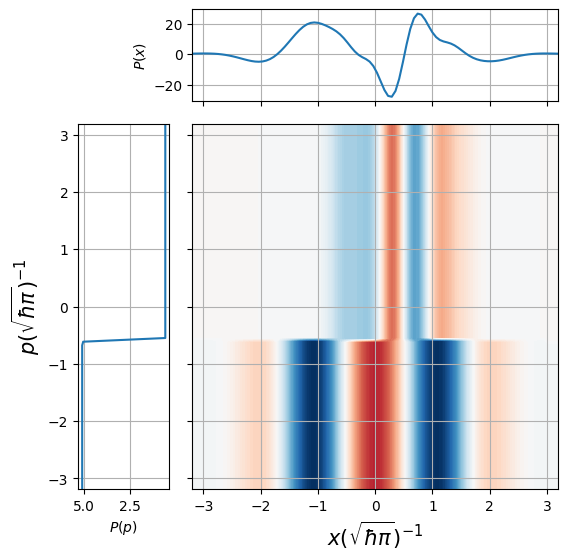

In [125]:
plot_wigner_marginals(W,x,x,'',)


In [95]:
t0 = time()
data = state.means, state.covs, state.weights, state.probability
W = get_wigner(data, x,x)
tf = time()
print(tf-t0)

0.7502129077911377


5.6726977825164795


/Users/s163967/venv/mrmustard_test/lib/python3.12/site-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/s163967/venv/mrmustard_test/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


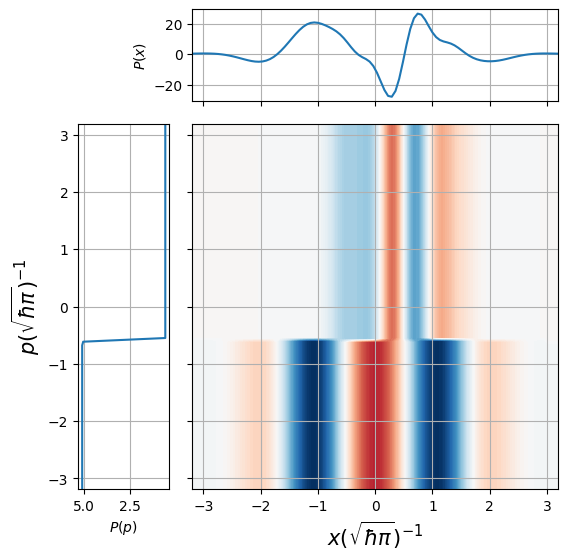

In [97]:
def get_wigner_bosonic(data, xvec, pvec):
    ## Adapted from strawberryfields.backends.states for BaseBosonicState
    
    means, covs, weights, norm = data
    X, P = np.meshgrid(xvec, pvec, sparse=True)
    
    wigner = 0
    for i, weight_i in enumerate(weights):
    
        if X.shape == P.shape:
            arr = np.array([X - means[i, 0], P - means[i, 1]])
            arr = arr.squeeze()
        else:
            # need to specify dtype for creating an ndarray from ragged
            # sequences
            arr = np.array([X - means[i, 0], P - means[i, 1]], dtype=object)
        
        exp_arg = arr @ np.linalg.inv(covs[0]) @ arr
        prefactor = 1 / (np.sqrt(np.linalg.det(2 * np.pi * covs[0])))
        wigner += (weight_i * prefactor) * np.exp(-0.5 * (exp_arg))/norm
    return np.real_if_close(wigner)

0.4219651222229004


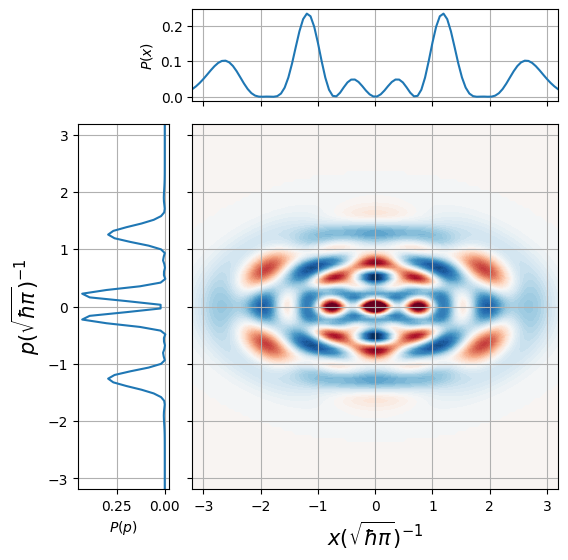

In [98]:
t0 = time()
W=get_wigner_bosonic(data,x,x)
tf = time()
print(tf-t0)
plot_wigner_marginals(W,x,x,'')
plt.show()